In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# 检查GPU是否可用
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# 数据预处理和加载
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=10, shuffle=False)

In [3]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # 编码器
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(64, 32)   # 均值
        self.fc_logvar = nn.Linear(64, 32)  # 方差的对数
        
        # 解码器
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# 实例化模型并移动到GPU
model = VAE().to(device)

In [4]:
# 定义损失函数
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    # KLD是KL散度损失
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [6]:
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for data in train_loader:
        img, _ = data
        img = img.view(img.size(0), -1).to(device)

        optimizer.zero_grad()
        recon_batch, mu, logvar = model(img)
        loss = loss_function(recon_batch, img, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss/len(train_loader.dataset):.4f}')

Epoch [1/3], Loss: 156.7917
Epoch [2/3], Loss: 132.8071
Epoch [3/3], Loss: 124.2313


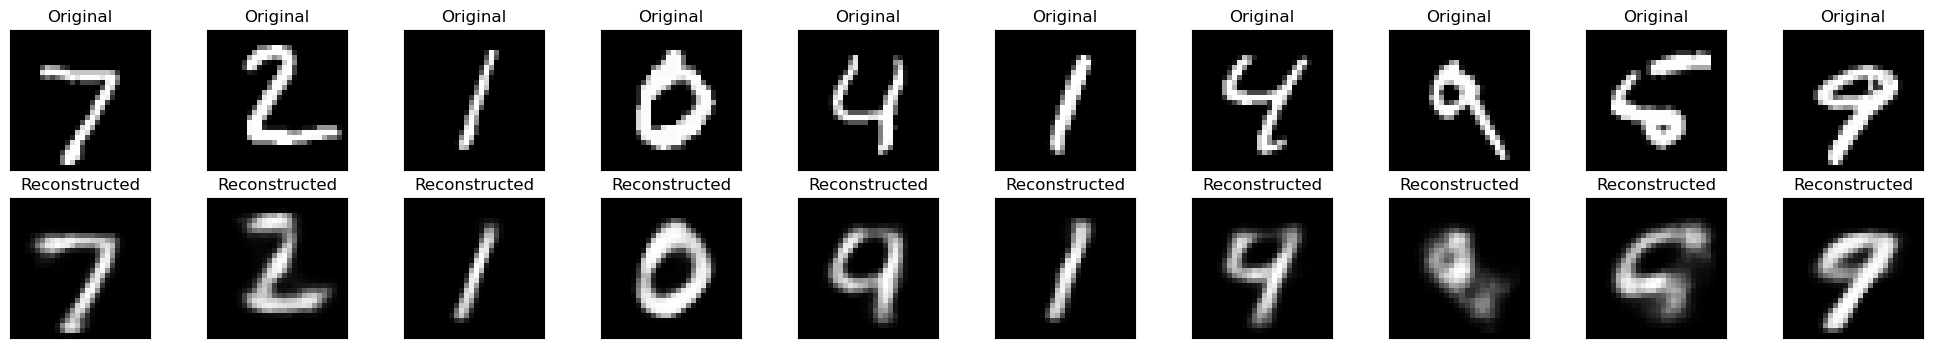

In [7]:
# 获取一些测试数据
dataiter = iter(test_loader)
images, _ = next(dataiter)
images = images.view(images.size(0), -1).to(device)

# 使用VAE重构图像
model.eval()
with torch.no_grad():
    recon_images, _, _ = model(images)

# 将重构结果从GPU移动到CPU，并调整维度以便可视化
recon_images = recon_images.view(recon_images.size(0), 1, 28, 28).cpu().data
images = images.view(images.size(0), 1, 28, 28).cpu().data

# 可视化原始图像和重构图像
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# 绘制原始图像
for i in range(10):
    axes[0, i].imshow(images[i].numpy().squeeze(), cmap='gray')
    axes[0, i].get_xaxis().set_visible(False)
    axes[0, i].get_yaxis().set_visible(False)
    axes[0, i].set_title("Original")

# 绘制重构图像
for i in range(10):
    axes[1, i].imshow(recon_images[i].numpy().squeeze(), cmap='gray')
    axes[1, i].get_xaxis().set_visible(False)
    axes[1, i].get_yaxis().set_visible(False)
    axes[1, i].set_title("Reconstructed")

plt.show()

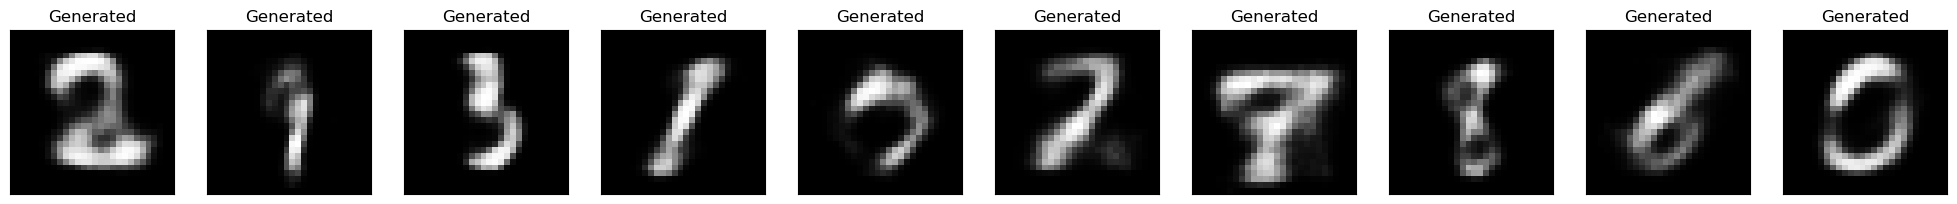

In [8]:
# 从潜在空间中抽取随机向量，生成新图像
num_samples = 10
random_latent_vectors = torch.randn(num_samples, 32).to(device)  # 抽取随机向量
with torch.no_grad():
    generated_images = model.decode(random_latent_vectors)

# 将生成结果从GPU移动到CPU，并调整维度以便可视化
generated_images = generated_images.view(num_samples, 1, 28, 28).cpu().data

# 可视化生成的新图像
fig, axes = plt.subplots(nrows=1, ncols=10, sharex=True, sharey=True, figsize=(25,4))

for i in range(10):
    axes[i].imshow(generated_images[i].numpy().squeeze(), cmap='gray')
    axes[i].get_xaxis().set_visible(False)
    axes[i].get_yaxis().set_visible(False)
    axes[i].set_title("Generated")

plt.show()